[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Ice Skating Figure Jump Analysis**

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/<BLOG_NAME>)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

## Overview

This project implements an end-to-end computer vision and kinematics pipeline for automated figure skating jump analysis. By integrating skeletal pose estimation with deep learning and physics-based angular tracking, the system provides objective metrics for athletic performance, specifically focusing on jump classification and rotation precision.

#### Key Features:
* **Automated Jump Classification:** Utilizes an LSTM-based deep learning model to recognize specific jump types (Axel, Salchow, Toe Loop, etc.) with high accuracy.
* **Kinematic Rotation Counting:** A physics engine that tracks 3D hip displacement to count total body revolutions in real-time.
* **Skeletal Pose Estimation:** Leverages MediaPipe to track 33 key body landmarks for bio-mechanical analysis.
* **Offline Analytics:** Supports frame-by-frame video processing to generate annotated broadcast-style overlays.

#### Real-World Applications:
* **Olympic Broadcast Overlays:** Real-time data visualization for viewers and commentators during international competitions.
* **Professional Coaching:** Providing athletes with precise data on air time, jump height, and rotation completeness.
* **Objective Judging:** Assisting technical panels with verifiable metrics to evaluate "under-rotated" or "downgraded" jumps.
* **Injury Prevention:** Monitoring skeletal alignment and landing impact forces through bio-mechanical tracking.
* **Automated Scouting:** Processing large datasets of training footage to identify and track athlete progress over time.

---

## Technical Architecture

The system operates through a multi-stage pipeline designed to handle the high-velocity movements inherent in figure skating:

1. **Pose Extraction:** High-fidelity 3D landmark detection using MediaPipe Pose.
2. **Feature Normalization:** Landmark coordinates are centered and scaled relative to the hip center to ensure the model remains invariant to camera distance and skater height.
3. **Sequential Classification:** A 150-frame temporal buffer is passed to a Long Short-Term Memory (LSTM) network, which analyzes the motion patterns over time to classify the jump.
4. **Angular Displacement Logic:** The physics engine calculates the arctangent of the hip landmarks across the X and Z (depth) axes to accumulate total degrees of rotation while the skater is in the air.

## Dataset Preparation & Taxonomy Mapping

The following script is used to organize raw video data from multiple camera angles into a structured dataset. It categorizes specific figure skating jumps into a four-class taxonomy optimized for our LSTM classification model.

### 4-Class Taxonomy Mapping:
| Class Name | Jump Types Included |
| :--- | :--- |
| **Class_0_Axel** | Axel |
| **Class_1_Edge** | Salchow, Loop |
| **Class_2_Complex_Pick** | Lutz, Flip |
| **Class_3_Simple_Pick** | Toe Loop |

### Technical Implementation:
The script traverses the `BASE_PATH` (unzipped camera folders), identifies `.mp4` files, and uses string splitting to extract the jump identity. It then performs a lookup against the `TAXONOMY` dictionary and copies the files to the `OUTPUT_PATH` while prepending the camera ID to prevent filename collisions.

In [4]:
import os
import shutil
# Path to your unzipped folder from the screenshot
BASE_PATH = "D:\\Downloads\\skater_A\\skater_A"
# New root for organized training data
OUTPUT_PATH = "D:\\Desktop\\Desk\\Labellerr Github Projects\\Use_Case_Projects\\olympics_cv_project\\organized_dataset"

# Define your 4-class taxonomy
TAXONOMY = {
    "Class_0_Axel": ["axel"],
    "Class_1_Edge": ["salchow", "loop"],
    "Class_2_Complex_Pick": ["lutz", "flip"],
    "Class_3_Simple_Pick": ["toeloop", "toe_loop"] # Catches both variations
}

def organize_files():
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    
    for cam_folder in os.listdir(BASE_PATH):
        cam_path = os.path.join(BASE_PATH, cam_folder)
        
        if os.path.isdir(cam_path) and cam_folder.startswith("cam"):
            for file_name in os.listdir(cam_path):
                if file_name.endswith(".mp4"):
                    # Lowercase the name to match taxonomy keys
                    jump_id = file_name.split("_")[0].lower()
                    
                    for class_name, keywords in TAXONOMY.items():
                        if jump_id in keywords:
                            dest_dir = os.path.join(OUTPUT_PATH, class_name)
                            os.makedirs(dest_dir, exist_ok=True)
                            
                            # Prefix with cam folder to avoid filename conflicts
                            new_name = f"{cam_folder}_{file_name}"
                            shutil.copy(os.path.join(cam_path, file_name), os.path.join(dest_dir, new_name))
    print("Files successfully organized into 4 classes!")

if __name__ == "__main__":
    organize_files()

Files successfully organized into 4 classes!


## Diverse Frame Extraction for Validation

The following utility script is used to generate a representative image dataset from the raw video footage. These frames are essential for verifying pose estimation accuracy and creating a small-scale image dataset for YOLOv11-pose fine-tuning.

### Technical Implementation:
The script crawls the `organized_dataset` directory and selects 50 unique videos. For each video, it identifies the total frame count and seeks to a random temporal position using `cv2.CAP_PROP_POS_FRAMES` to capture a diverse snapshot of the skater's movement.

In [ ]:
import cv2
import os
import random

# Your organized dataset path
DATASET_PATH = "organized_dataset"
OUTPUT_IMAGES = "img_dataset"


os.makedirs(OUTPUT_IMAGES, exist_ok=True)

def extract_diverse_frames(total_needed=50):
    all_videos = []
    
    for root, dirs, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(".mp4"):
                all_videos.append(os.path.join(root, file))
    
    print(f"Found {len(all_videos)} video clips.")
    
    
    selected_vids = random.sample(all_videos, min(total_needed, len(all_videos)))
    
    count = 0
    for video_path in selected_vids:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames > 0:
            
            frame_index = random.randint(0, total_frames - 1)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            
            success, frame = cap.read()
            if success:
            
                vid_name = os.path.basename(video_path).split('.')[0]
                img_name = f"skater_{vid_name}_f{frame_index}.jpg"
                cv2.imwrite(os.path.join(OUTPUT_IMAGES, img_name), frame)
                count += 1
                
        cap.release()
        if count >= total_needed:
            break

    print(f"Successfully extracted {count} unique frames to {OUTPUT_IMAGES}")

if __name__ == "__main__":
    extract_diverse_frames(50)

Found 720 video clips.
Successfully extracted 50 unique frames to img_dataset


## Annotate your Custom dataset using Labellerr

 ***1. Visit the [Labellerr](https://www.labellerr.com/?utm_source=githubY&utm_medium=social&utm_campaign=github_clicks) website and click **“Sign Up”**.*** 

 ***2. After signing in, create your workspace by entering a unique name.***

 ***3. Navigate to your workspace’s API keys page (e.g., `https://<your-workspace>.labellerr.com/workspace/api-keys`) to generate your **API Key** and **API Secret**.***

 ***4. Store the credentials securely, and then use them to initialise the SDK or API client with `api_key`, `api_secret`.*** 



## Download Annotations from Labellerr

After completing data labeling on the **Labellerr** platform, export the annotations in **COCO JSON format**.

Download the COCO JSON file from the Labellerr website and upload it into this project workspace to use it for further dataset preparation and training.

This COCO JSON file will be used in the next steps for:
- Frame–annotation alignment
- COCO → YOLO format conversion
- Model training and evaluation


In [8]:
!git clone https://github.com/Labellerr/yolo_finetune_utils.git

Cloning into 'yolo_finetune_utils'...


# COCO to YOLO Format Conversion

Converts COCO-style segmentation annotations to YOLO segmentation dataset format.  
- Requires: `annotation.json` and images in `frames_output` directory.
- Output: Generated YOLO dataset folder.
- Parameters: allows train/val split, shuffling, and verbose mode.


In [11]:
from yolo_finetune_utils.coco_yolo_converter.bbox_converter import coco_to_yolo_converter

coco_to_yolo_converter(
    json_path="export-#KfOtkMikXutSyD5AlN0q.json",
    images_dir="img_dataset",
    output_dir="yolo_img_dataset",
    use_split=True,
    train_ratio=0.7,
    val_ratio=0.2,
    test_ratio=0.1,
    verbose=True
)

Loading COCO dataset from export-#KfOtkMikXutSyD5AlN0q.json
Found 50 images and 46 annotations
Categories mapping:
  COCO ID 0 (Skater) -> YOLO class 0
Images with annotations: 46
Dataset split:
  train: 32 images
  val: 9 images
  test: 5 images

Processing train split...

Processing val split...

Processing test split...

Conversion completed:
  Successfully processed: 46 images
  Failed to find: 0 images
  Total annotations converted: 46
  Categories: 1

YOLO dataset created at: yolo_img_dataset
Dataset configuration: yolo_img_dataset\dataset.yaml


{'output_path': 'yolo_img_dataset',
 'yaml_path': 'yolo_img_dataset\\dataset.yaml',
 'stats': {'total_images': 50,
  'images_with_annotations': 46,
  'successful_copies': 46,
  'failed_copies': 0,
  'total_annotations': 46,
  'categories': 1,
  'category_mapping': {0: 0},
  'class_names': {0: 'Skater'}}}

## YOLO11 Model Fine-Tuning

The following code block handles the training phase for the skater detection model. This stage is critical for ensuring the AI can reliably locate the athlete before the LSTM analyzes their specific movements.

### Training Parameters:
| Parameter | Value | Description |
| :--- | :--- | :--- |
| **Model** | YOLO11 Nano | Optimized for low-latency performance. |
| **Epochs** | 100 | Full passes through the training dataset. |
| **Img Size** | 640 | Resolution for input image processing. |
| **Batch** | 16 | Number of images processed before the model updates. |

In [13]:
from ultralytics import YOLO

# 1. Load the pre-trained YOLO11 Nano model (best for small datasets)
model = YOLO("yolo11n.pt") 

# 2. Train the model
results = model.train(
    data="yolo_img_dataset/dataset.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    name="skater_detector_v1",
    project="olympics_cv",
    device="cpu"  # Change this from 0 to 'cpu'
)

Ultralytics 8.4.9  Python-3.13.1 torch-2.10.0+cpu CPU (12th Gen Intel Core(TM) i5-1235U)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_img_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=skater_detector_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

## Skater Tracking & Inference

After training, the model is deployed to track athletes in raw video footage. This tracking step is the bridge between static object detection and temporal motion analysis.

### Tracking Parameters:
| Configuration | Value | Purpose |
| :--- | :--- | :--- |
| **Tracker** | ByteTrack | Optimized for high-velocity motion and occlusion handling. |
| **Persist** | True | Maintains Skater ID consistency across the entire video clip. |
| **Confidence** | 0.4 | Minimum probability required to consider a detection valid. |

In [18]:
import cv2
from ultralytics import YOLO

# 1. Load your best model
model = YOLO("runs/detect/olympics_cv/skater_detector_v1/weights/best.pt")

# 2. Path to your test video
video_path = "organized_dataset/Class_0_Axel/cam_1_Axel_1.mp4"

# 3. Run tracking
# persist=True: maintains the same ID for the skater across frames
# tracker="bytetrack.yaml": Highly efficient for fast-moving sports
results = model.track(
    source=video_path, 
    persist=True, 
    tracker="bytetrack.yaml", 
    save=True,
    conf=0.4
)

print(f"Tracking complete! Video saved in: {results[0].save_dir}")


WARNING 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/300) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\olympics_cv_project\organized_dataset\Class_0_Axel\cam_1_Axel_1.mp4: 384x640 (no detections), 104.6ms
video 1/1 (frame 2/300) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\olympics_cv_project\organized_dataset\Class_0_Axel\cam_1_Axel_1.mp4: 384x640 (no detections), 78.8ms
video 1/1 (frame 3/300) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\olympi

## Skeleton Overlay & Video Inference

The following script generates an annotated video showing the real-time skeletal tracking of the skater. This is used to verify that the pose estimation is accurate enough for the subsequent LSTM classification stage.

### Inference Parameters:
| Setting | Value | Description |
| :--- | :--- | :--- |
| **Padding (PAD)** | 0.20 | 20% buffer added to YOLO box for stable pose tracking. |
| **Model Complexity** | 2 | Uses MediaPipe's "Heavy" model for maximum landmark precision. |
| **Codec** | mp4v | Standard MP4 compression for the output file. |

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from ultralytics import YOLO


yolo_model = YOLO("runs/detect/olympics_cv/skater_detector_v1/weights/best.pt")
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils


input_path = "organized_dataset/Class_0_Axel/cam_1_Axel_1.mp4"
cap = cv2.VideoCapture(input_path)


frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)


output_path = "inference_check_axel.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

PAD = 0.20 

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    
    results = yolo_model.track(frame, persist=True, verbose=False)
    
    if results[0].boxes.id is not None:
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            bw, bh = x2 - x1, y2 - y1
            
           
            pw, ph = int(bw * PAD), int(bh * PAD)
            cx1, cy1 = max(0, x1 - pw), max(0, y1 - ph)
            cx2, cy2 = min(w, x2 + pw), min(h, y2 + ph)
            
            crop = frame[cy1:cy2, cx1:cx2]
            if crop.size == 0: continue
            
            
            results_pose = pose.process(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            
            if results_pose.pose_landmarks:
                
                mp_drawing.draw_landmarks(
                    crop, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                
                frame[cy1:cy2, cx1:cx2] = crop

    
    out.write(frame)
    
    cv2.imshow("Inference Check", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): break


cap.release()
out.release() 
cv2.destroyAllWindows()

print(f"Inference video saved as: {output_path}")

Inference video saved as: inference_check_axel.mp4


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from ultralytics import YOLO

# 1. Initialize YOLO and Legacy MediaPipe
yolo_model = YOLO("runs/detect/olympics_cv/skater_detector_v1/weights/best.pt")
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# 2. Setup Video Input and Output
input_path = "organized_dataset/Class_1_Edge/cam_2_loop_1.mp4"
cap = cv2.VideoCapture(input_path)

# Get video properties for the writer
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize VideoWriter (Saves as .mp4)
output_path = "inference_check_edge.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

PAD = 0.20 # 20% Padding

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # YOLO Tracking
    results = yolo_model.track(frame, persist=True, verbose=False)
    
    if results[0].boxes.id is not None:
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            bw, bh = x2 - x1, y2 - y1
            
            # Apply Padding
            pw, ph = int(bw * PAD), int(bh * PAD)
            cx1, cy1 = max(0, x1 - pw), max(0, y1 - ph)
            cx2, cy2 = min(w, x2 + pw), min(h, y2 + ph)
            
            crop = frame[cy1:cy2, cx1:cx2]
            if crop.size == 0: continue
            
            # MediaPipe Pose Estimation
            results_pose = pose.process(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            
            if results_pose.pose_landmarks:
                # Draw landmarks directly on the crop
                mp_drawing.draw_landmarks(
                    crop, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                # Overlay crop back onto the original frame
                frame[cy1:cy2, cx1:cx2] = crop

    # WRITE the annotated frame to your video file
    out.write(frame)
    
    cv2.imshow("Inference Check", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): break

# 3. Clean up
cap.release()
out.release() # CRITICAL: If you don't release, the video will be corrupt
cv2.destroyAllWindows()

print(f"Inference video saved as: {output_path}")

Inference video saved as: inference_check_edge.mp4


In [6]:
import cv2
import mediapipe as mp
import numpy as np
from ultralytics import YOLO

# 1. Initialize YOLO and Legacy MediaPipe
yolo_model = YOLO("runs/detect/olympics_cv/skater_detector_v1/weights/best.pt")
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# 2. Setup Video Input and Output
input_path = "organized_dataset/Class_2_Complex_Pick/cam_3_Flip_1.mp4"
cap = cv2.VideoCapture(input_path)

# Get video properties for the writer
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize VideoWriter (Saves as .mp4)
output_path = "inference_check_complex_pick.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

PAD = 0.20 # 20% Padding

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # YOLO Tracking
    results = yolo_model.track(frame, persist=True, verbose=False)
    
    if results[0].boxes.id is not None:
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            bw, bh = x2 - x1, y2 - y1
            
            # Apply Padding
            pw, ph = int(bw * PAD), int(bh * PAD)
            cx1, cy1 = max(0, x1 - pw), max(0, y1 - ph)
            cx2, cy2 = min(w, x2 + pw), min(h, y2 + ph)
            
            crop = frame[cy1:cy2, cx1:cx2]
            if crop.size == 0: continue
            
            # MediaPipe Pose Estimation
            results_pose = pose.process(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            
            if results_pose.pose_landmarks:
                # Draw landmarks directly on the crop
                mp_drawing.draw_landmarks(
                    crop, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                # Overlay crop back onto the original frame
                frame[cy1:cy2, cx1:cx2] = crop

    # WRITE the annotated frame to your video file
    out.write(frame)
    
    cv2.imshow("Inference Check", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): break

# 3. Clean up
cap.release()
out.release() # CRITICAL: If you don't release, the video will be corrupt
cv2.destroyAllWindows()

print(f"Inference video saved as: {output_path}")

Inference video saved as: inference_check_complex_pick.mp4


In [11]:
import cv2
import mediapipe as mp
import numpy as np
from ultralytics import YOLO

# 1. Initialize YOLO and Legacy MediaPipe
yolo_model = YOLO("runs/detect/olympics_cv/skater_detector_v1/weights/best.pt")
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# 2. Setup Video Input and Output
input_path = "organized_dataset/Class_3_Simple_Pick/cam_9_Toeloop_4.mp4"
cap = cv2.VideoCapture(input_path)

# Get video properties for the writer
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Initialize VideoWriter (Saves as .mp4)
output_path = "inference_check_simple_pick.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

PAD = 0.20 # 20% Padding

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    # YOLO Tracking
    results = yolo_model.track(frame, persist=True, verbose=False)
    
    if results[0].boxes.id is not None:
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            bw, bh = x2 - x1, y2 - y1
            
            # Apply Padding
            pw, ph = int(bw * PAD), int(bh * PAD)
            cx1, cy1 = max(0, x1 - pw), max(0, y1 - ph)
            cx2, cy2 = min(w, x2 + pw), min(h, y2 + ph)
            
            crop = frame[cy1:cy2, cx1:cx2]
            if crop.size == 0: continue
            
            # MediaPipe Pose Estimation
            results_pose = pose.process(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            
            if results_pose.pose_landmarks:
                # Draw landmarks directly on the crop
                mp_drawing.draw_landmarks(
                    crop, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                # Overlay crop back onto the original frame
                frame[cy1:cy2, cx1:cx2] = crop

    # WRITE the annotated frame to your video file
    out.write(frame)
    
    cv2.imshow("Inference Check", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): break

# 3. Clean up
cap.release()
out.release() # CRITICAL: If you don't release, the video will be corrupt
cv2.destroyAllWindows()

print(f"Inference video saved as: {output_path}")

Inference video saved as: inference_check_simple_pick.mp4


## Skeletal Feature Extraction Pipeline

The following stage transforms raw video data into a series of 3D skeletal landmarks. This numerical representation is what allows the LSTM model to "understand" the motion of a jump without being distracted by background colors or rink lighting.

### Pipeline Workflow:
| Stage | Description | Technical Detail |
| :--- | :--- | :--- |
| **Tracking** | YOLOv11-Tracking | Maintains a consistent bounding box on the skater using GPU acceleration. |
| **Cropping** | Dynamic ROI | Crops the frame around the skater with a 20% padding buffer to prevent limb clipping. |
| **Pose Estimation** | MediaPipe Pose | Extracts 33 keypoints (x, y, z, visibility) from the localized crop. |
| **Normalization** | Global Re-projection | Maps landmarks from the local crop back to the original video dimensions (0.0 to 1.0). |

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
from ultralytics import YOLO

# 1. Setup GPU-accelerated Models
DRIVE_PATH = "/content/drive/MyDrive"
yolo_model = YOLO(f"{DRIVE_PATH}/best (2).pt").to('cuda')
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=2, min_detection_confidence=0.5)

# 2. Paths
DATASET_DIR = f"{DRIVE_PATH}/organized_dataset"
OUTPUT_DIR = f"{DRIVE_PATH}/processed_skeleton_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PAD = 0.20 # The 20% padding for fast jumps

def extract_skeleton(video_path):
    cap = cv2.VideoCapture(video_path)
    sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        h, w, _ = frame.shape

        # YOLO Tracking on GPU
        results = yolo_model.track(frame, persist=True, verbose=False, device=0)

        # Default: 33 points with 4 values (x,y,z,v) all set to 0
        frame_landmarks = np.zeros((33, 4))

        if results[0].boxes.id is not None:
            # Detect first skater
            box = results[0].boxes.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = map(int, box)
            bw, bh = x2 - x1, y2 - y1

            # Padded Crop for MediaPipe
            cx1, cy1 = max(0, x1 - int(bw*PAD)), max(0, y1 - int(bh*PAD))
            cx2, cy2 = min(w, x2 + int(bw*PAD)), min(h, y2 + int(bh*PAD))
            crop = frame[cy1:cy2, cx1:cx2]

            if crop.size > 0:
                res = pose.process(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
                if res.pose_landmarks:
                    # Convert to re-projected full-frame normalized coordinates
                    frame_landmarks = np.array([
                        [(lm.x * (cx2-cx1) + cx1)/w, (lm.y * (cy2-cy1) + cy1)/h, lm.z, lm.visibility]
                        for lm in res.pose_landmarks.landmark
                    ])

        sequence.append(frame_landmarks)

    cap.release()
    return np.array(sequence)

# 3. Execution Loop
print("Starting GPU Skeleton Extraction...")
# Change from your old list to the actual names found on your drive:
for category in ["Class_0_Axel", "Class_1_Edge", "Class_2_Complex_Pick", "Class_3_Simple_Pick"]:
    cat_path = os.path.join(DATASET_DIR, category)
    out_cat_path = os.path.join(OUTPUT_DIR, category)
    os.makedirs(out_cat_path, exist_ok=True)

    for video in os.listdir(cat_path):
        if video.endswith(".mp4"):
            save_path = os.path.join(out_cat_path, video.replace(".mp4", ".npy"))
            if not os.path.exists(save_path):
                data = extract_skeleton(os.path.join(cat_path, video))
                np.save(save_path, data)
                print(f"Saved: {category}/{video} (Frames: {len(data)})")

print("All 720 clips processed!")

## LSTM Training & Sequential Modeling

This stage defines the neural network architecture and the data loading pipeline. The model is specifically designed to handle the variable-length nature of figure skating jumps by standardizing input sequences to a fixed temporal window.

### Model Specifications:
| Layer | Type | Configuration | Purpose |
| :--- | :--- | :--- | :--- |
| **Input** | Sequential | (150, 132) | 150 frames of 33 landmarks (x,y,z,v). |
| **LSTM 1** | Bidirectional | 64 Units | Captures temporal dependencies in both directions. |
| **Dropout** | Regularization | 0.5 | Prevents overfitting on small athletic datasets. |
| **Output** | Dense | 4 Units (Softmax) | Classifies the jump into the 4-class taxonomy. |

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Update this to your local folder path
DATA_PATH = "D:/olympics_cv_project/processed_skeleton_data" 
actions = np.array(['Class_0_Axel', 'Class_1_Edge', 'Class_2_Complex_Pick', 'Class_3_Simple_Pick'])
label_map = {label:num for num, label in enumerate(actions)}
MAX_SEQUENCE_LENGTH = 150 # 5 Seconds @ 30fps

## Skeletal Normalization & Preprocessing

The following script implements spatial and scale normalization for the skeletal data. This step is essential for training a robust model that generalizes across different camera angles and athlete body types.

### Normalization Workflow:
| Technique | Description | Mathematical Goal |
| :--- | :--- | :--- |
| **Centering** | Sets origin at hip midpoint. | Eliminate positional bias (x, y, z translation). |
| **Scaling** | Normalizes by torso height. | Eliminate camera distance and height bias. |
| **Padding** | Concatenates zero-arrays. | Standardize input shape to 150 frames. |
| **Flattening** | Reshapes (33, 4) to (132,) | Prepare features for LSTM input layers. |

In [ ]:
def normalize_skeleton(frame_data):
    """ Centers skater at hips and scales by body height. """
    
    hip_center = (frame_data[23, :3] + frame_data[24, :3]) / 2
    normalized = frame_data.copy()
    normalized[:, :3] = frame_data[:, :3] - hip_center
    
    shoulder_center = (frame_data[11, :3] + frame_data[12, :3]) / 2
    scale_dist = np.linalg.norm(shoulder_center - hip_center)
    
    if scale_dist > 0:
        normalized[:, :3] = normalized[:, :3] / scale_dist
        
    return normalized

print("Loading, normalizing, and preprocessing skeletal data...")
sequences, labels = [], []

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_path): continue
    
    for npy_file in os.listdir(action_path):
        res = np.load(os.path.join(action_path, npy_file))
        
        
        res_norm = np.array([normalize_skeleton(frame) for frame in res])
        
        if len(res_norm) < MAX_SEQUENCE_LENGTH:
            padding = np.zeros((MAX_SEQUENCE_LENGTH - len(res_norm), 33, 4))
            res_norm = np.concatenate([res_norm, padding], axis=0)
        else:
            res_norm = res_norm[:MAX_SEQUENCE_LENGTH]
            
        sequences.append(res_norm.flatten().reshape(MAX_SEQUENCE_LENGTH, -1))
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data ready. X_train shape: {X_train.shape}")

Loading, normalizing, and preprocessing skeletal data...
Data ready. X_train shape: (576, 150, 132)


## Bidirectional LSTM Model Definition

The following code defines the neural network architecture used to achieve high-accuracy jump classification. This model takes the normalized 150-frame skeletal sequences as input and outputs the predicted jump category.

### Model Summary & Layer Stack:
| Layer (type) | Output Shape | Param # | Description |
| :--- | :--- | :--- | :--- |
| **Bidirectional (LSTM)** | (None, 150, 128) | 100,864 | Processes temporal skeletal landmarks forward and backward. |
| **Dropout (0.3)** | (None, 150, 128) | 0 | Regularization layer to prevent overfitting. |
| **Bidirectional (LSTM)** | (None, 256) | 263,168 | Second temporal layer for high-level motion patterns. |
| **Dense (ReLU)** | (None, 64) | 16,448 | Fully connected decision layer. |
| **Dense (Softmax)** | (None, 4) | 260 | Final output for 4-class jump taxonomy. |

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh'), 
                        input_shape=(MAX_SEQUENCE_LENGTH, 132)))
model.add(Dropout(0.3)) 


model.add(Bidirectional(LSTM(128, return_sequences=False, activation='tanh')))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 150, 128)       │       100,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,740 (1.45 MB)

 Trainable params: 380,740 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training Execution

The following code block initiates the training loop. This process transforms the raw skeletal data into a predictive AI model capable of classifying competitive skating jumps.

### Training Workflow:
| Metric | Value | Purpose |
| :--- | :--- | :--- |
| **Training Samples** | ~576 | 80% of the total dataset used for weight optimization. |
| **Validation Samples** | ~144 | 20% of the dataset used to verify accuracy. |
| **Epochs** | 100 | Duration of the training session. |
| **Format** | .keras | Modern, single-file model serialization. |

In [11]:
print(f"Starting training on {len(X_train)} samples...")

# Train the model (shuffle is True by default in Keras)
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

# Save the final model in the modern Keras format
model.save('skating_jump_classifier.keras')
print("Model saved as 'skating_jump_classifier.keras'")

Starting training on 576 samples...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 469ms/step - categorical_accuracy: 0.3142 - loss: 1.3662 - val_categorical_accuracy: 0.2986 - val_loss: 1.3318
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - categorical_accuracy: 0.3854 - loss: 1.2960 - val_categorical_accuracy: 0.3333 - val_loss: 1.2701
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step - categorical_accuracy: 0.4201 - loss: 1.2371 - val_categorical_accuracy: 0.4028 - val_loss: 1.2101
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - categorical_accuracy: 0.4688 - loss: 1.1829 - val_categorical_accuracy: 0.4306 - val_loss: 1.1551
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 395ms/step - categorical_accuracy: 0.4861 - loss: 1.1422 - val_categorical_accuracy: 0.4722 - val_loss: 1.0914
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - categorical_accuracy: 0.5538 - loss: 1.0770 - val_categorical_accuracy: 0.4792 - val_loss: 1.0398
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 499

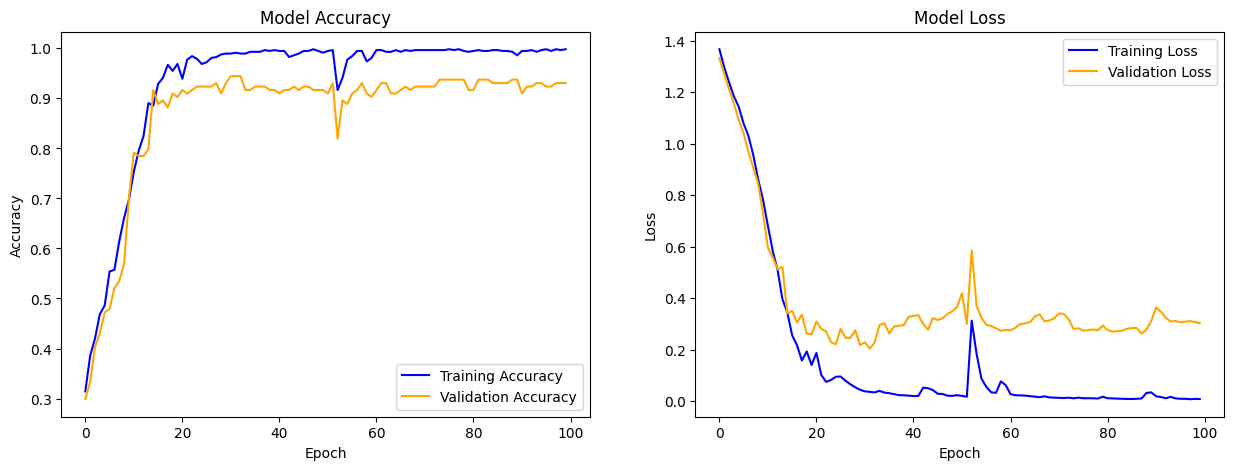

In [12]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Categorical Accuracy
ax1.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss', color='blue')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

## Real-Time Jump & Rotation Analysis

The following script is the primary inference engine. It integrates the trained LSTM model with a custom physics layer to provide a comprehensive breakdown of skating performance in a single video output.

### Pipeline Features:
| Feature | Technical Implementation | Goal |
| :--- | :--- | :--- |
| **Jump Detection** | LSTM Sequence Buffer (150 frames) | Identify Axel, Edge, or Pick-based jumps. |
| **Rotation Counting** | Angular Velocity Accumulation | Calculate total natural number revolutions (1, 2, 3...). |
| **Air-Time Logic** | Hip-Height Thresholding | Automate the start/stop of rotation tracking. |
| **Visualization** | OpenCV Rectangle & DUPLEX Fonts | Create a professional broadcast-style overlay. |

In [ ]:

from tensorflow.keras.models import load_model

MODEL_PATH = "skating_jump_classifier.keras"

if os.path.exists(MODEL_PATH):
    model = load_model(MODEL_PATH)
    print(f"✅ Model loaded successfully from {MODEL_PATH}")
else:
    print(f"❌ Error: {MODEL_PATH} not found. Please check the file path.")
import cv2
import numpy as np
import mediapipe as mp
import keras 
import tensorflow as tf

video_path = "organized_dataset\Class_0_Axel\cam_2_Axel_3.mp4"
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter('alex2_rotations.mp4', fourcc, fps, (frame_width, frame_height))

actions = ['Axel', 'Edge Jump', 'Complex Pick', 'Simple Pick']
sequence_buffer = []
is_in_air = False
gliding_y, cal_frames = 0, 0
current_label = "Scanning..."

total_revolutions = 0
accumulated_degrees = 0
previous_angle = 0

print(f" Starting Analysis for Revolutions...")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    results = mp_pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    if results.pose_landmarks:
        landmarks = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark])
        
        hip_center = (landmarks[23, :3] + landmarks[24, :3]) / 2
        norm_landmarks = landmarks.copy()
        norm_landmarks[:, :3] -= hip_center
        sequence_buffer.append(norm_landmarks.flatten())
        sequence_buffer = sequence_buffer[-150:]

        left_hip, right_hip = landmarks[23], landmarks[24]
        curr_y = (left_hip[1] + right_hip[1]) / 2
        
        current_angle = np.degrees(np.arctan2(right_hip[2] - left_hip[2], 
                                              right_hip[0] - left_hip[0]))

        if cal_frames < 30:
            gliding_y += curr_y / 30
            cal_frames += 1
            previous_angle = current_angle
        else:
            if curr_y < (gliding_y - 0.04) and not is_in_air:
                is_in_air = True
                accumulated_degrees = 0 
                total_revolutions = 0
            
            elif curr_y >= (gliding_y - 0.02) and is_in_air:
                is_in_air = False

            if is_in_air:
                delta = current_angle - previous_angle
                
                if delta > 180: delta -= 360
                elif delta < -180: delta += 360
                
                accumulated_degrees += abs(delta)
                total_revolutions = accumulated_degrees / 360
            
            previous_angle = current_angle

        
        if len(sequence_buffer) == 150:
            input_data = np.expand_dims(sequence_buffer, axis=0).astype('float32')
            preds = model(input_data, training=False)
            current_label = actions[np.argmax(preds.numpy()[0])]
 

        display_revs = int(total_revolutions) 
        
        
        box_size = 200
        top_left = (20, 20)
        bottom_right = (170 + box_size, box_size)
        
        cv2.rectangle(frame, top_left, bottom_right, (0, 0, 0), -1)
        
        font = cv2.FONT_HERSHEY_DUPLEX 
        font_scale_main = 1.5
        font_scale_sub = 0.9
        thickness_standard = 1 

        
        cv2.putText(frame, f"{current_label}", (40, 80), 
                    font, font_scale_main, (0, 255, 0), thickness_standard)
        
       
        cv2.putText(frame, f"REVS: {display_revs}", (40, 160), 
                    font, font_scale_main, (0, 255, 255), thickness_standard)
        
        
        mp.solutions.drawing_utils.draw_landmarks(frame, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)

    out.write(frame)


cap.release()
out.release()
cv2.destroyAllWindows()
print("\n✅ DONE! Check 'output_rotations.mp4' for the revolution count.")

▶️ Starting Analysis for Revolutions...

✅ DONE! Check 'output_rotations.mp4' for the revolution count.


---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
